##Implementation and understanding of tensorflow dataset API and creating tfrecourd of Flickr8k dataset

In [1]:
!pip install tensorflow

In [2]:
!pip install nltk

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from random import shuffle
from collections import Counter
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import nltk.tokenize
import numpy as np
import cv2

%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Preprocessing Data

In [0]:
def load_caption_data(address):
    dataset_caption_addrs = address
    with tf.gfile.FastGFile(dataset_caption_addrs, "r") as file:
      text = file.read()    
    datatxt = {}
    for line in text.split('\n'):
       col = line.split('\t')
       if len(col) == 1:
           continue
       w = col[0].split("#")
       if w[0] not in datatxt:
          datatxt[w[0]] = [col[1].lower()]
       else:
          datatxt[w[0]].append(col[1].lower())
    return datatxt

In [0]:
image_caption_dict= load_caption_data('/content/gdrive/My Drive/Flickr8k_text/Flickr8k.token.txt')

In [0]:
def load_image_data(address):
    dataset_image_addrs = address
    with tf.gfile.FastGFile(dataset_image_addrs, "r") as file:
      text = file.read()
    file.close()
    image_names = text.split("\n")
    img_caption={}
    for names in image_names:
        if names != '':
            for i in range(len(image_caption_dict[names])):
                img_caption[str(i+1)+'/content/gdrive/My Drive/Flickr8k_Dataset/Flicker8k_Dataset/'+names]= image_caption_dict[names][i] 
    return img_caption


In [0]:
train_img = load_image_data('/content/gdrive/My Drive/Flickr8k_text/Flickr_8k.trainImages.txt')

'people at a distance trying to climb a cliff .'

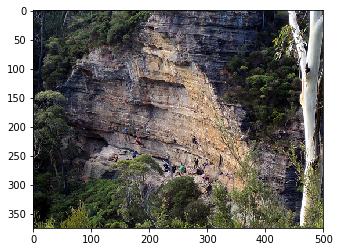

In [0]:
plt.imshow(mpimg.imread(list(train_img.keys())[503][1:]))
plt.show
list(train_img.values())[503]

In [0]:
def _process_caption(caption):
    tokenized_caption = ["<S>"]
    tokenized_caption.extend(nltk.tokenize.word_tokenize(caption.lower()))
    tokenized_caption.append("</S>")
    length_tokenized_caption = len(tokenized_caption)
    return tokenized_caption, length_tokenized_caption

In [0]:
class vocabulary(object):
    def __init__(self, word_index_vocab, index_word_vocab, unk_id, max_length):
        self._word_index_vocab = word_index_vocab
        self._index_word_vocab = index_word_vocab
        self._unk_id = unk_id
        self._max_length = max_length
    def word_to_id(self,word):
        if word in (self._word_index_vocab).keys()  :
            return (self._word_index_vocab)[word]
        else:
            return self._unk_id

In [0]:
def _create_vocab(image_captions_dict):
    max_length= 0
    counter = Counter()
    captions=list(image_captions_dict .values())
    for c in captions:
        word_list, length = _process_caption(c.lower())
        counter.update(word_list)
        if length> max_length:
            max_length= length
    word_counts = [x for x in counter.items() if x[1] >= 4]
    word_counts.sort(key=lambda x: x[1], reverse=True)
    print("Words in vocabulary:", len(word_counts))
    reverse_vocab = [x[0] for x in word_counts]
    unk_id = len(reverse_vocab)
    word_index_vocab_dict = dict([(x, y+1) for (y, x) in enumerate(reverse_vocab)])
    index_word_vocab_dict = dict([(y+1, x) for (y, x) in enumerate(reverse_vocab)])
    vocab = vocabulary( word_index_vocab_dict, index_word_vocab_dict, unk_id, max_length)
    return vocab

In [0]:
vocab = _create_vocab(train_img)
vocab_size= 2931
print("maximum length of caption is "+ str(vocab._max_length))
print('a' in (vocab._word_index_vocab).keys())
print((vocab._word_index_vocab)['a'])

Words in vocabulary: 2931
maximum length of caption is 40
True
1


##Creating Tensorflow record of flickr8k daraset

In [0]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _bytes_feature_list(values):
    return tf.train.FeatureList(feature=[_bytes_feature(v) for v in values])

def _int64_feature_list(values):
    return tf.train.FeatureList(feature=[_int64_feature(v) for v in values])

In [0]:
def load_image(addrs):
    img = mpimg.imread(addrs[1:])
    img = cv2.resize(img, (299, 299))
    img = img.astype(np.float32)
    img = img/255
    return img, addrs[1:] 

<class 'numpy.ndarray'>
<class 'bytes'>
<class 'tensorflow.core.example.feature_pb2.Feature'>
Flickr8k_Dataset/Flicker8k_Dataset/121800200_bef08fae5f.jpg


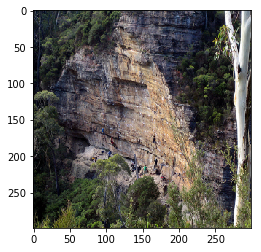

In [0]:
image, address = load_image(list(train_img.keys())[502])
print(type(image))
image_raw = image.tostring()
print(type(image_raw))
bf= _bytes_feature(image_raw)
print(type(bf))
plt.imshow(image)
print(address)

In [0]:
num_threads = 8
train_shards = 128
batch_size = 32
num_shards_per_batch = train_shards/num_threads 
images_per_shard = 46
drive_address = "/content/gdrive/My Drive/"

In [0]:
def convert_to (name , dataset, num_shards, images_per_shard):
    images= list(dataset.keys())
    captions= list(dataset.values())
    num_examples= len(images)
    
    counter = 0
    for shard in range(num_shards):
      output_filename = "%s-%.5d-of-%.5d" % (name, shard, num_shards)
      output_file = os.path.join(drive_address, output_filename)
    
    
      with tf.python_io.TFRecordWriter(output_file) as writer:
        for index in range(shard*images_per_shard, (shard+1)*images_per_shard):
            if index == len(images)-1:
              return
            image_raw, image_address = load_image(images[index]) 
            image_raw = image_raw.tostring()
            context = tf.train.Features(
               feature={
                    "image_raw": _bytes_feature(image_raw),
                       })
            caption, caption_len = _process_caption(captions[index])
            caption_ids = [vocab.word_to_id(word) for word in caption]
            feature_lists=tf.train.FeatureLists(
                 feature_list={
                    "caption_ids": _int64_feature_list(caption_ids),
                      })
            sequence_example = tf.train.SequenceExample(context=context, feature_lists=feature_lists)
            writer.write(sequence_example.SerializeToString())   

In [0]:
convert_to(name= "train", dataset= train_img, num_shards= train_shards, images_per_shard= images_per_shard )

***tf records created***

##Retrieving data in the form of batches using tensorflow dataset API

In [0]:
def dynamic_pad_input(caption_id):
    caption_length = tf.shape(caption_id)[0]
    input_caption_length = tf.expand_dims(tf.subtract(caption_length,1),0)
    input_caption = tf.slice(caption_id, [0], input_caption_length)
    leng = tf.constant(40)-tf.size(input_caption)
    zeros= tf.zeros(leng, tf.int64)
    input_caption = tf.concat([input_caption, zeros],0)
    
    return input_caption

In [0]:
def dynamic_pad_target(caption_id):
    caption_length = tf.shape(caption_id)[0]
    input_caption_length = tf.expand_dims(tf.subtract(caption_length,1),0)
    leng = tf.constant(40)-input_caption_length
    zeros= tf.zeros(leng, tf.int64)
    target_seq = tf.slice(caption_id, [1], input_caption_length)
    target_seq = tf.concat([target_seq, zeros],0)
    zeros = tf.
    return target_seq

In [0]:
def dynamic_pad_mask(caption_id):
    caption_length = tf.shape(caption_id)[0]
    input_caption_length = tf.expand_dims(tf.subtract(caption_length,1),0)
    leng = tf.constant(40)- input_caption_length
    zeros= tf.zeros(leng, tf.int64)
    indicator = tf.ones(input_caption_length, dtype=tf.int64)
    indicator = tf.concat([indicator,zeros],0)
    return indicator

In [0]:
def _parse_sequence_example(dataset):
    image_feature= "image_raw"
    caption_feature= "caption_ids"
    context, sequence = tf.parse_single_sequence_example(
    serialized= dataset,
    context_features= {
         image_feature: tf.FixedLenFeature([], dtype=tf.string)
    },
    sequence_features= {
         caption_feature: tf.FixedLenSequenceFeature([], dtype=tf.int64),
    })
    encoded_image = context[image_feature]
    decoded_image = tf.decode_raw(encoded_image, tf.float32)
    decoded_image = tf.reshape(decoded_image, [299, 299, 3])
    caption = sequence[caption_feature]
    input_seq = dynamic_pad_input(caption)
    target_seq = dynamic_pad_target(caption)
    mask = dynamic_pad_mask(caption)
    return decoded_image, input_seq, target_seq, mask

In [0]:
input_caption = dynamic_pad_input(tf.constant([1,2,3,4,5,6,7], tf.int64))
target_seq = dynamic_pad_target(tf.constant([1,2,3,4,5,6,7], tf.int64))
indicator = dynamic_pad_mask(tf.constant([1,2,3,4,5,6,7], tf.int64))
with tf.Session() as sess:
    print(sess.run(input_caption))
    print(sess.run(target_seq))
    print(sess.run(indicator))

[1 2 3 4 5 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[2 3 4 5 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


In [0]:
def input_single_example(files_pattern):     
    
    files = tf.gfile.Glob(files_pattern)
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(_parse_sequence_example,num_parallel_calls=4)
    dataset = dataset.batch(batch_size=32)
    dataset = dataset.prefetch(1)
    iterator = dataset.make_one_shot_iterator()
    images, input_seqs, target_seqs , mask= iterator.get_next() 
    
    return images, input_seqs, target_seqs , mask

In [0]:
images, input_seqs, target_seqs , mask= input_single_example("/content/gdrive/My Drive/train*")
#with tf.Session() as sess:
#    print(plt.imshow(sess.run(images)[2]))
#    print(sess.run([input_seqs,target_seqs,mask]))
print(images)
print(input_seqs)
print(target_seqs)


Tensor("Reshape_31:0", shape=(32, 299, 299, 3), dtype=float32)
Tensor("Reshape_32:0", shape=(32, 40), dtype=int64)
Tensor("Reshape_33:0", shape=(32, 40), dtype=int64)
